<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/unit%208%20project%20rhea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Temperature in Tokyo

In [1]:
#import everything
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import requests

In [2]:
#install pymc-bart
!pip install pymc pymc-bart

In [3]:
# Fetch weather data from Open-Meteo API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=35.68&longitude=139.76&start_date=2023-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,pressure_msl,wind_speed_10m,soil_temperature_0_to_10cm&timezone=UTC"

In [4]:
# Make API request with error handling
try:
    response = requests.get(url)
    response.raise_for_status()
    weather = response.json()
except requests.RequestException as e:
    print(f"Error fetching data: {e}")
    raise

In [5]:
# Check if 'hourly' data exists
if "hourly" not in weather:
    print("Error: 'hourly' key not found in API response")
    print("API response:", weather)
    raise KeyError("'hourly' key missing")

In [6]:
# Create DataFrame
hourly_data = weather["hourly"]
df = pd.DataFrame({
    "temperature_2m": hourly_data["temperature_2m"],
    "relative_humidity_2m": hourly_data["relative_humidity_2m"],
    "dew_point_2m": hourly_data["dew_point_2m"],
    "precipitation": hourly_data["precipitation"],
    "pressure_msl": hourly_data["pressure_msl"],
    "wind_speed_10m": hourly_data["wind_speed_10m"],
    "soil_temperature_0_to_10cm": hourly_data["soil_temperature_0_to_10cm"]
})

In [7]:
# Inspect missing values
print(f"Initial DataFrame shape: {df.shape}")
print("Missing values per column:\n", df.isna().sum())

Initial DataFrame shape: (8760, 7)
Missing values per column:
 temperature_2m                   0
relative_humidity_2m             0
dew_point_2m                     0
precipitation                    0
pressure_msl                     0
wind_speed_10m                   0
soil_temperature_0_to_10cm    8760
dtype: int64


In [8]:
# dropping NA and checking result
df_clean = df.dropna()
print(f"DataFrame shape after dropna: {df_clean.shape}")

DataFrame shape after dropna: (0, 7)


In [9]:
if df_clean.empty:
    print("Error: DataFrame is empty after dropping NA")
    # Check for non-NaN missing values
    print("Sample of first 5 rows before dropna:\n", df.head())
    reliable_cols = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "pressure_msl"]
    print(f"Falling back to subset of columns: {reliable_cols}")
    df = df[reliable_cols]
    print("Missing values in subset:\n", df.isna().sum())
    df_clean = df.dropna()
    print(f"DataFrame shape after fallback dropna: {df_clean.shape}")
    if df_clean.empty:
        print("Error: Still no data after fallback")
        raise ValueError("No usable data after cleaning")

Error: DataFrame is empty after dropping NA
Sample of first 5 rows before dropna:
    temperature_2m  relative_humidity_2m  dew_point_2m  precipitation  \
0             2.6                    81          -0.3            0.0   
1             5.7                    73           1.3            0.0   
2             7.9                    66           1.9            0.0   
3             9.3                    57           1.3            0.0   
4            10.0                    59           2.3            0.0   

   pressure_msl  wind_speed_10m soil_temperature_0_to_10cm  
0        1021.9             8.2                       None  
1        1021.0             2.8                       None  
2        1020.0             1.0                       None  
3        1018.7             3.0                       None  
4        1017.6             8.6                       None  
Falling back to subset of columns: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'pressure_msl']
Missing 

In [10]:
# Select features and target
features = ["relative_humidity_2m", "dew_point_2m", "pressure_msl"]
X = df_clean[features].to_numpy()
Y = df_clean["temperature_2m"].to_numpy()

Relative humidity is a fundamental predictor because it measures the ratio of actual water vapor to the maximum the air can hold, which depends exponentially on temperature; warmer air increases saturation vapor pressure, often lowering relative humidity if moisture is constant, making it a sensitive indicator of temperature changes, especially in Tokyo’s humid climate. Dew point, the temperature at which air becomes saturated, reflects absolute moisture content and is closely tied to temperature, as temperature cannot drop below dew point without condensation, providing a stable measure that complements relative humidity’s temperature dependence. Mean sea level pressure captures large-scale weather systems—high pressure typically brings clear, warmer conditions, while low pressure signals clouds and cooler temperatures.

These predictors were therefore prioritized over others like precipitation (often zero, better for classification), wind speed (weaker direct effect on temperature), and soil temperature.

In [11]:
# Verify data shapes
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (8760, 3), Y shape: (8760,)


In [17]:
# Define and fit the model
with pm.Model() as model_weather:
    s = pm.HalfNormal("s", 500)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    y = pm.Normal("y", mu=μ_, sigma=s, observed=Y)
    idata_weather = pm.sample(compute_convergence_checks=False)

Output()

Interactions are significant: relative humidity and dew point interact non-linearly, as high dew points with high temperatures yield high humidity (e.g., sticky summer days), while low dew points with similar temperatures indicate drier conditions; pressure modulates this, with low pressure amplifying humidity’s cooling effect (e.g., rainy, humid days) and high pressure enhancing warming (clear, drier days)

Output()

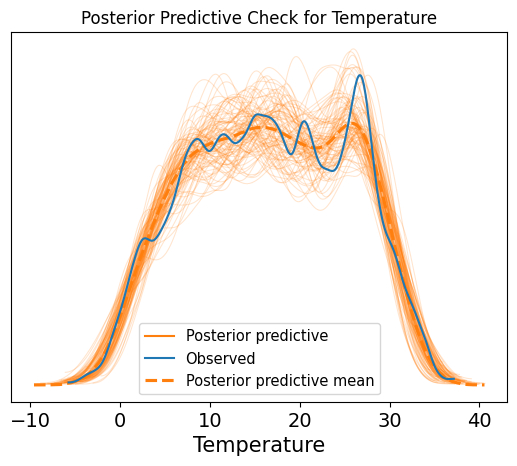

In [14]:
# Sample posterior predictive
pm.sample_posterior_predictive(idata_weather, model=model_weather, extend_inferencedata=True)

# Plot posterior predictive check
ax = az.plot_ppc(idata_weather, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_title("Posterior Predictive Check for Temperature")
ax.set_xlabel("Temperature")
plt.show()

I think that the model did alright overall. The observed line ended up generally matching with the posterior predictive lines.